In [389]:
import numpy as np 

import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import math
%matplotlib inline 

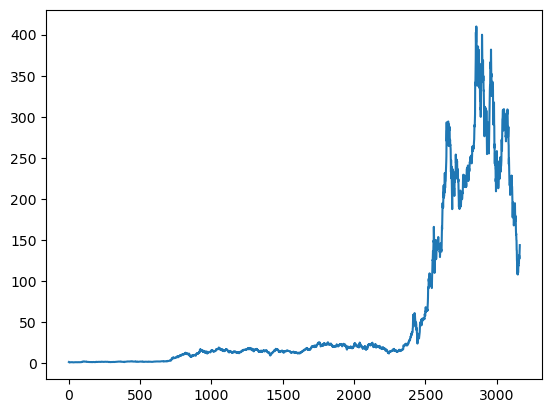

In [390]:
df = pd.read_csv('../TSLA.csv')
plt.plot(df['Adj Close'])
plt.show()

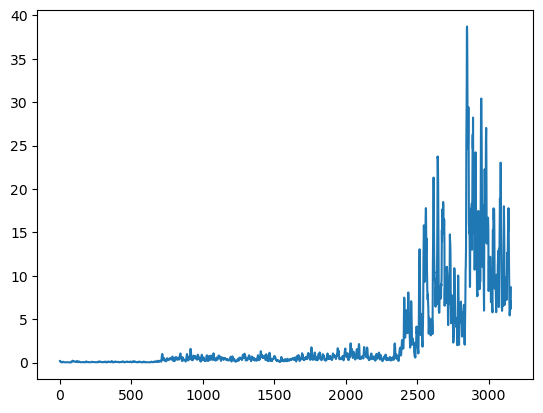

In [391]:
windows = 10
data = df['Adj Close'].rolling(windows).std()[windows-1:].values
plt.plot(data)
plt.show()

In [413]:
eta = 1e-3;  epsilon = 1e-2

In [414]:
c_scale = 6
def func(x):
    # x in range [0, 1]
    id_ = int(np.floor(x*len(data)))
    reward = data[id_] * c_scale
    
    observation = np.random.normal(reward, 0.1)
    return reward, observation - reward

In [415]:
delta = 1e-3
MAX_REWARD = np.max(data) * c_scale
delta_MAX = np.quantile(data, 1-delta) * c_scale

In [416]:
class cube():
    
    def __init__(self, x1_left, x1_right, parent, children, xs, ys, bmo = True):
#         print("options: {0}".format(option)) 
        self.x1_left = x1_left
        self.x1_right = x1_right
    
        self.parent = parent
        self.children = children
        
        self.xs = xs
        self.ys = ys
            
        self.bmo = False    
    
    def is_terminal(self):
        
        if len(self.children) == 0:
            return True
        else:
            return False
        
    def is_preparent(self):
        
        is_preparent = False
        
        for c in self.children:
            if c.is_terminal(): 
                return True
        
        return False
    
    def is_parent( self ):
        
        if self.parent is None:
            return True
        
        if self.parent.is_preparent():
            return False
        else:
            return True
        
    def measure(self): 
        
        return (self.x1_right - self.x1_left)
    
    def insert_point(self, x1, y): 
        
        if (x1 >= self.x1_left ) & (x1 <= self.x1_right ):
                        
            self.xs = list(self.xs) + [[x1]] 
            self.ys = list(self.ys) + [y] 
            
    def insert_all_children(self, x1, y):
        
        self.insert_point(x1, y) 
        
#         if len(self.children) > 0: 
            
        for j in range(len(self.children)):

            q = self.children[j]

            q.insert_all_children(x1, y) 

    
#     def observe(self, x1, x2, y):
        
# #         self.insert_point(x1, x2 , y)
        
#         self.insert_all_children( x1, x2, y)
        
#         self.update_children()
        
    def get_terminals( self ):
        
#         terminals = []
        
        if len(self.children) == 0:
            return [self] 
                            
        l0 = self.children[0].get_terminals()
        l1 = self.children[1].get_terminals()
        
        return l0 + l1
    
    
    def get_all_cubes(self ):
                
        if len(self.children) == 0:
            return [self] 
                            
        l0 = self.children[0].get_terminals() 
        l1 = self.children[1].get_terminals() 
        
        return [self] + l0 + l1
        
#         self.children
        
#         self.xs.append(x) 
#         self.ys.append(y) 
        
#         self.update()
        
    def m(self): 
        
        return np.mean(self.ys) 
    
    def n(self):
        
        return len(self.ys)
    
    def get_parent(self):
        
        if self.parent is None:
            return self
        
        else:
            if self.parent.is_parent():
#                 if self.parent.colored == False:
#                     self.parent.colored = True
                return self.parent
#                 else:
#                     return 'colored'
            else:
                return self.parent.get_parent() 
            
    def reset_color(self):

        self.colored = False
        
#     def U(self):
        
#         return self.m() + 

In [417]:
def update_children(c, bmo = True, alpha=1):
    global split_times
    
    
    terminals = c.get_terminals() 

    updated = False

    for q in terminals: 

        if bmo : 
#             condition = (np.sqrt(np.log(T/epsilon))/np.sqrt( max([1,q.n()]) ) < alpha * np.log( q.measure() / eta ) )
#             print((np.sqrt(np.log(T/epsilon))/np.sqrt( max([1,q.n()]) ),  np.log( q.measure() / eta )) )
            
            condition = (np.log(T**2/epsilon))*np.sqrt(np.log(T**2/epsilon))/np.sqrt( max([1,q.n()]) ) < alpha * np.log( q.measure() / eta )
        else:
            condition = (np.sqrt(np.log(T/epsilon))/np.sqrt( 1 + q.n() ) < (q.x1_right - q.x1_left) )

        if condition: 
            split_times += 1

            updated = True

            l_children = 0

            x1_mid = (q.x1_right + q.x1_left) / 2. 

            xs = np.array( q.xs ).copy(); ys = np.array( q.ys ).copy() 
            xs1 = xs[:,0].copy()
    
            xs_tmp = xs[ (xs1 < x1_mid), : ].copy()
            ys_tmp = ys[ (xs1 < x1_mid) ].copy()


            l_children += len(ys_tmp)

            q1 = cube( q.x1_left, x1_mid, 
                      q, [  ], xs_tmp, ys_tmp, bmo )

#                 x1_left, x1_right, x2_left, x2_right, parent, children, xs, ys, bmo = True

            xs = np.array( q.xs ).copy(); ys = np.array( q.ys ).copy() 
            xs1 = xs[:,0].copy()
            xs_tmp = xs[ (xs1 >= x1_mid), : ].copy()
            ys_tmp = ys[ (xs1 >= x1_mid)  ].copy()

            l_children += len(ys_tmp)

            q2 = cube( x1_mid, q.x1_right, 
                      q, [  ], xs_tmp, ys_tmp, bmo )

            q.children = [q1, q2] 

    return updated

In [418]:
N = 10000; eta = 1e-4; T = 2 * N

# bandit-bmo-z

In [419]:
from tqdm import tqdm
arms = []; rewards = []; avg_rewards = []

split_times = 0

for dummy in range(10):
    
    rewards_tmp = []; avg_rewards_tmp = []
    
    print(dummy)
    
    root = cube( 0, 1., None, [], [], [], True )

    for t in tqdm(range(N)): 
#         print(split_times, t)

        terminals = root.get_terminals() 

        parents = []; Us = []; rs = []; ns = []; children_ns = []

        for q in terminals:
            p = q.get_parent()
            if p not in parents:
                parents.append(q.get_parent())

        for q in parents:
    
#             u = q.m() + np.sqrt( np.log(T/epsilon) ) / np.sqrt( max([1, q.n()] ) ) +\
#                        max([0, np.log( q.measure() / eta )  ] )
        
            u = q.m() + (np.log(T**2/epsilon))*np.sqrt(np.log(T**2/epsilon))/np.sqrt( max([1,q.n()]) ) +\
                       max([0, np.log( q.measure() / eta )  ] )

            Us.append( u ) 

            rs.append( q.x1_right - q.x1_left )
            ns.append( len(q.ys) ) 

            for i in range(len(q.children)):

                children_ns.append( len(q.children[i].ys) ) 

        selected = parents[ np.argmax( Us ) ]

        if len( selected.children ) == 0:

            x1 = np.random.uniform( selected.x1_left , selected.x1_right )

            reward, noise = func(x1) 

            root.insert_all_children( x1, reward + noise )

            updated = True 

            while updated:

                updated = update_children(root, alpha=30)

            arms.append((x1))

            rewards_tmp.append( reward ) 
            
#             xs1 = np.random.uniform( selected.x1_left ,selected.x1_right, size = (1000,1) )
            
#             avg_reward = np.mean( func(xs1)[0] )
            
#             avg_rewards_tmp.append(avg_reward)

        else:

            for j in range(2):

                x1 = np.random.uniform( selected.children[j].x1_left , selected.children[j].x1_right )

                reward, noise = func(x1) 

                root.insert_all_children( x1, reward + noise )

                updated = True

                while updated:
                    
                    updated = update_children(root)

                arms.append((x1))
                
                rewards_tmp.append( reward ) 
                
#                 xs1 = np.random.uniform( selected.children[j].x1_left , selected.children[j].x1_right, size = (1000,1) )
#                 xs1 = np.random.uniform(selected.children[j].x1_left , selected.children[j].x1_right)

#                 avg_reward = np.mean( func(xs1)[0] )

#                 avg_rewards_tmp.append(avg_reward)

    rewards.append( rewards_tmp ) 
    
#     avg_rewards.append(avg_rewards_tmp)

0


  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\asd\anaconda3\envs\pytorch\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\asd\anaconda3\envs\pytorch\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 10000/10000 [02:05<00:00, 79.63it/s]


1


100%|██████████| 10000/10000 [02:07<00:00, 78.65it/s]


2


100%|██████████| 10000/10000 [02:06<00:00, 78.97it/s]


3


100%|██████████| 10000/10000 [02:01<00:00, 82.22it/s]


4


100%|██████████| 10000/10000 [02:01<00:00, 82.33it/s]


5


100%|██████████| 10000/10000 [02:02<00:00, 81.87it/s]


6


100%|██████████| 10000/10000 [01:58<00:00, 84.51it/s]


7


100%|██████████| 10000/10000 [02:00<00:00, 82.66it/s]


8


100%|██████████| 10000/10000 [01:59<00:00, 83.46it/s]


9


100%|██████████| 10000/10000 [01:59<00:00, 83.87it/s]


In [420]:
# rewards, avg_rewards = pickle.load(open('bmo-bandit-z-res','rb')) 
regrets_bmoz = []; delta_regrets_bmoz = []

for j in range(len(rewards)): 
    
    regret_tmp = []; delta_regret_tmp = []; 

    for i in range(len(rewards[j])):
#         reward = np.exp((rewards[j][i] * 2.427) + 8.693)
#         MAX_REWARD_ = np.exp(MAX_REWARD * 2.427 + 8.693)
#         delta_MAX_ = np.exp(delta_MAX * 2.427 + 8.693)
#         regret = max([0, MAX_REWARD_ - reward])
#         delta_regret = max([0, delta_MAX_ - avg_rewards[j][i]])
        
        regret = max([0, MAX_REWARD - rewards[j][i] ]) 
        delta_regret = max([0, delta_MAX - rewards[j][i] ])  
        
        regret_tmp.append(regret) 
        
        delta_regret_tmp.append( delta_regret )
        
    regrets_bmoz.append( regret_tmp ) 
    delta_regrets_bmoz.append( delta_regret_tmp )

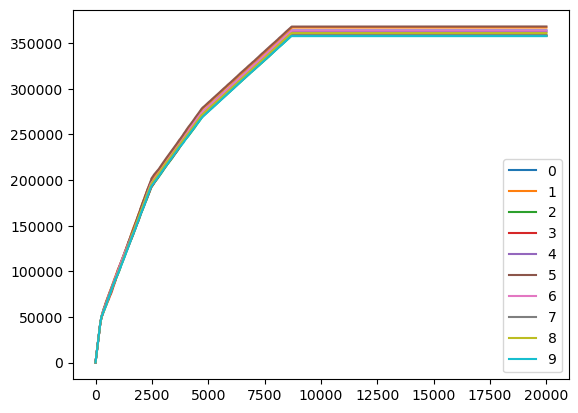

In [421]:
# for i in range(dummy):
#     data_delta = np.cumsum( regrets_bmoz[i] )
#     data = np.cumsum(regrets_bmoz[i])
#     plt.plot( data_delta, label='{}'.format(i) ) 
# plt.legend()
# plt.show()

for i in range(10):
    data_delta = np.cumsum( delta_regrets_bmoz[i] )
    plt.plot( data_delta, label='{}'.format(i) ) 
plt.legend()
plt.show()

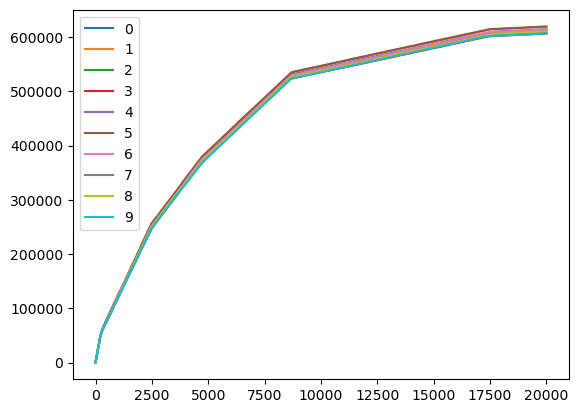

In [422]:
for i in range(10):
    data_ = np.cumsum(regrets_bmoz[i])
    plt.plot(data_, label='{}'.format(i) ) 
plt.legend()
plt.show()

In [423]:
# regret_m = np.mean(np.cumsum(regrets_bmoz, axis=1), axis=0)
# regret_std = np.std(np.cumsum(regrets_bmoz, axis=1), axis=0)
regret_m_delta = np.mean(np.cumsum(delta_regrets_bmoz, axis=1), axis=0)
regret_std_delta = np.std(np.cumsum(delta_regrets_bmoz, axis=1), axis=0)

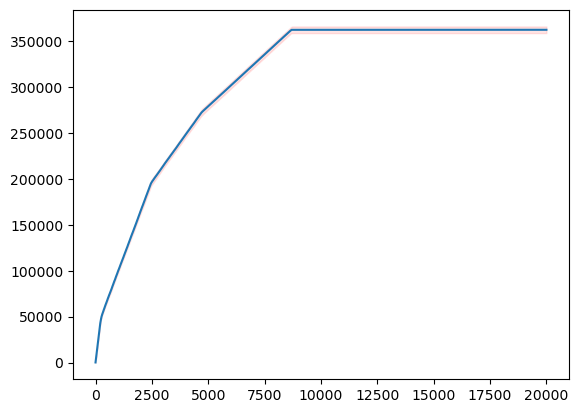

In [424]:
# plt.plot(regret_m)
plt.plot(regret_m_delta)
# plt.fill_between(np.array(range(len(regret_m))), 
#                  regret_m - regret_std, regret_m + regret_std, alpha=0.1, color='b')
plt.fill_between(np.array(range(len(regret_m_delta))), 
                                regret_m_delta - regret_std_delta, regret_m_delta + regret_std_delta, alpha=0.1, color='r')
plt.show()

In [425]:
np.savetxt('bmoz_delta.csv', delta_regrets_bmoz)
np.savetxt('bmoz.csv', regrets_bmoz)

# bandit_bmo_p

In [426]:
from tqdm import tqdm

arms_p = []; rewards_p = []; avg_rewards_p = []; 

for dummy in range(10):
    
    split_times = 0
    
    print(dummy)
    
    rewards_tmp = []; avg_rewards_tmp = []
    
    root = cube( 0, 1., None, [], [], [], True )

    for t in tqdm(range(N*2)): 

        terminals = root.get_terminals() 

        Us = []; 

        for q in terminals:

            u = q.m() + (np.log(T**2/epsilon))*np.sqrt(np.log(T**2/epsilon))/np.sqrt( max([1,q.n()]) ) +\
                       max([0, np.log( q.measure() / eta )  ] )

            Us.append( u ) 

        selected = terminals[ np.argmax( Us ) ]

        x1 = np.random.uniform( selected.x1_left , selected.x1_right )

        reward, noise = func(x1) 

        root.insert_all_children( x1, reward + noise )

        updated = True 

        while updated:
            updated = update_children(root) 

        arms.append((x1))
        
        rewards_tmp.append( reward )
        
#         xs1 = np.random.uniform( selected.x1_left , selected.x1_right, size = (1000,1) )

#         avg_reward = np.mean( func(xs1)[0] )
        
#         avg_rewards_tmp.append( avg_reward ) 

    rewards_p.append( rewards_tmp ) 
    
#     avg_rewards.append( avg_rewards_tmp ) 


0


100%|██████████| 20000/20000 [01:15<00:00, 263.29it/s] 


1


100%|██████████| 20000/20000 [01:19<00:00, 251.22it/s] 


2


100%|██████████| 20000/20000 [01:22<00:00, 243.83it/s] 


3


100%|██████████| 20000/20000 [01:20<00:00, 249.03it/s] 


4


100%|██████████| 20000/20000 [01:20<00:00, 247.98it/s]


5


100%|██████████| 20000/20000 [01:19<00:00, 251.63it/s]


6


100%|██████████| 20000/20000 [01:20<00:00, 247.42it/s] 


7


100%|██████████| 20000/20000 [01:18<00:00, 255.10it/s] 


8


100%|██████████| 20000/20000 [01:18<00:00, 253.80it/s]


9


100%|██████████| 20000/20000 [01:21<00:00, 245.23it/s] 


In [427]:
regrets_bmop = []; delta_regrets_bmop = []

for j in range(len(rewards_p)): 
    
    regret_tmp = []; delta_regret_tmp = []; 

    for i in range(len(rewards_p[j])):
#         reward = np.exp((rewards[j][i] * 2.427) + 8.693)
#         MAX_REWARD_ = np.exp(MAX_REWARD * 2.427 + 8.693)
#         delta_MAX_ = np.exp(delta_MAX * 2.427 + 8.693)
#         regret = max([0, MAX_REWARD_ - reward])
#         delta_regret = max([0, delta_MAX_ - avg_rewards[j][i]])
        
        regret = max([0, MAX_REWARD - rewards_p[j][i] ]) 
        delta_regret = max([0, delta_MAX - rewards_p[j][i] ])  
        
        regret_tmp.append(regret) 
        
        delta_regret_tmp.append( delta_regret )
        
    regrets_bmop.append( regret_tmp ) 
    delta_regrets_bmop.append( delta_regret_tmp )

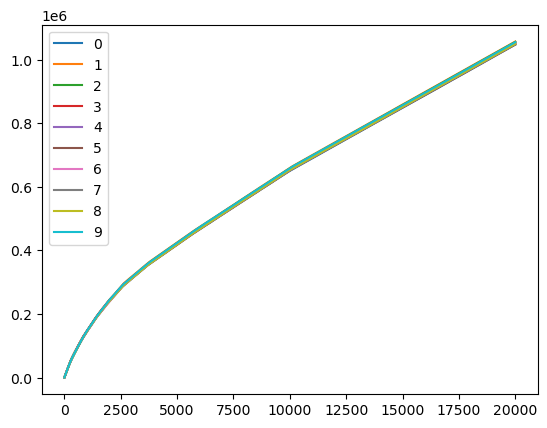

In [428]:
for i in range(10):
    data_delta = np.cumsum( delta_regrets_bmop[i] )
    plt.plot( data_delta, label='{}'.format(i) ) 
plt.legend()
plt.show()

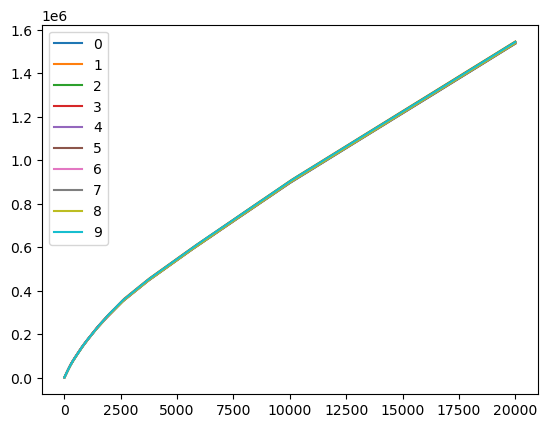

In [429]:
for i in range(10):
    data_ = np.cumsum(regrets_bmop[i])
    plt.plot(data_, label='{}'.format(i) ) 
plt.legend()
plt.show()

In [430]:
regret_m_delta = np.mean(np.cumsum(delta_regrets_bmop, axis=1), axis=0)
regret_std_delta = np.std(np.cumsum(delta_regrets_bmop, axis=1), axis=0)

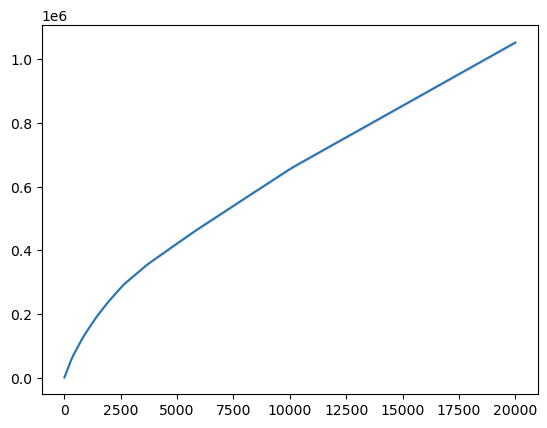

In [431]:
# plt.plot(regret_m)
plt.plot(regret_m_delta)
# plt.fill_between(np.array(range(len(regret_m))), 
#                  regret_m - regret_std, regret_m + regret_std, alpha=0.1, color='b')
plt.fill_between(np.array(range(len(regret_m_delta))), 
                                regret_m_delta - regret_std_delta, regret_m_delta + regret_std_delta, alpha=0.1, color='r')
plt.show()

In [432]:
np.savetxt('bmop_delta.csv', delta_regrets_bmop)
np.savetxt('bmop.csv', regrets_bmop)

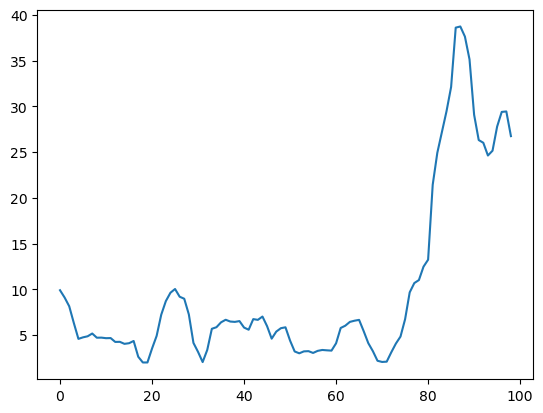

In [190]:
plt.plot(data[int(0.875*len(data)): int(0.90625*len(data))])

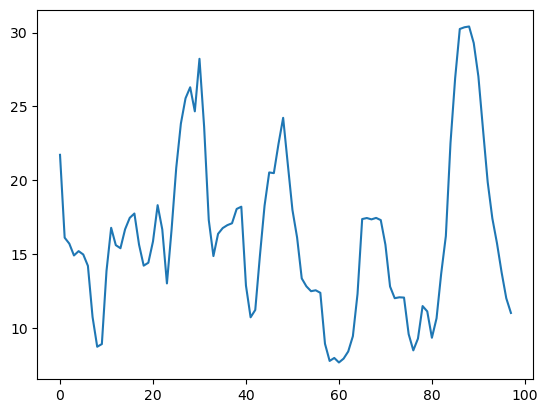

In [191]:
plt.plot(data[int(0.90625*len(data)): int(0.9375*len(data))])

In [136]:
data[int(0.915*len(data))]

25.547984525108863